In [5]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [6]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Data Description

#### Players Dataset

| Column Name  |  Data Type  |                            Description                             |
|--------------|-------------|--------------------------------------------------------------------|
| experience   | Categorical | Skill level: Beginner, Amateur, Regular, Veteran, Pro              |
| subscribe    | Boolean     | Whether the player is subscribed (TRUE/FALSE)                      |
| hashed_email | String      | Hashed email acting as player identification                       |
| played_hours | Float       | Total hours played                                                 |
| name         | String      | Name of player                                                     |
| gender       | Categorical | Male, Female, Non-binary, Two-Spirited, Agender, Prefer not to say |
| Age          | Integer     | Age of player                                                      |


**Key Observations**
- Number of Observations : 196
- Number of Variables : 7
- Issues observed:
    - The groupings for 'experience' may be subjective - different players may have different expectations of different experience levels
    - The long strings for 'hashed_email' make it difficult to verify if there are duplicate entries of the same player
    - There are extreme values for 'played_hours' such as 218.1 hours played, which may prove that there are outliers in the dataset
- Potential Issues:
    - It is unclear whether 'experience' is self-reported or officially assigned, which may lead to inaccurate results
    - Some categories such as a particular age range or skill level may be underrepresented, which may lead to data skew

In [7]:
hours_mean <- mean(players$played_hours)
hours_median <- median(players$played_hours)
hours_min <- min(players$played_hours)
hours_max <- max(players$played_hours)
# hours_mean
# hours_median
# hours_min
# hours_max

age_mean <- mean(players$Age, na.rm = TRUE)
age_median <- median(players$Age, na.rm = TRUE)
age_min <- min(players$Age, na.rm = TRUE)
age_max <- max(players$Age, na.rm = TRUE)
# age_mean
# age_median
# age_min
# age_max

**Summary Statistics for Players Dataset**

| Column Name  |  Mean  | Median | Min |  Max  |
|--------------|--------|--------|-----|-------|
| played_hours | 5.85   | 0.1    |  0  | 223.1 |
| Age          | 21.14  | 19     |  9  |  58   |


#### Sessions Dataset

| Column Name  |  Data Type  |                            Description                             |
|--------------|-------------|--------------------------------------------------------------------|
| hashed_email   | String | Hashed email of the player which acts as identification             |
| start_time    | Datetime     |  Starting timestamp of session                  |
| end_time | Datetime      | Ending timestamp of session                       |
| original_start_time | Numeric       | Timestamp of session start in milliseconds                                   |
| original_end_time         | Numeric      | Timestamp of session end in milliseconds                         |


**Key Observations**
- Number of Observations : 1535
- Number of Variables : 5
- Issues observed:
    -  The values of original_start_time and original_end_time are not easily readable by humans
    -  There is a very large range of time played, as the start and end times suggest that there are sessions that last for hours, and sessions that last only minutes
- Potential Issues:
    - As the values of hashed_email are not easily human readable, some users could have sessions that overlap in timestamps
        - Additionally, it is difficult to tell if the same session of the same user is logged more than once

## Question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

For this project, I will focus on the broad question of what player characteristics are more predictive of subscribing to a game-related newsletter. Specifically, I aim to answer the question of **"Can a player's in-game activity patterns, such as total playtime, number of sessions, and experience level, predict whether they are subscribed to a game-related newsletter?"**.

The Minecraft server logs provide data on each player's activity and session information, allowing me to summarise and use data wrangling to turn the data into summary statistics and metrics for each individual player. By summarising metrics such as total playtime, average session duration, number of sessions, and combining these with the player's subscription status, I will be able to create a dataset suitable for predicting whether player is subscribed to game-related newsletters based on their metrics. I feel that K-NN classification will be more suitable compared to linear regression to predict the subscription status of a player based on their summary metrics, because the relationship between the predictors and subscription status is likely to be non-linear.

## Exploratory Data Analysis and Data Visualisation

In [10]:
players_summary <- players |>
    summarise(mean_played_hours = mean(played_hours, na.rm = TRUE), mean_age = mean(Age, na.rm = TRUE))
players_summary

mean_played_hours,mean_age
<dbl>,<dbl>
5.845918,21.13918


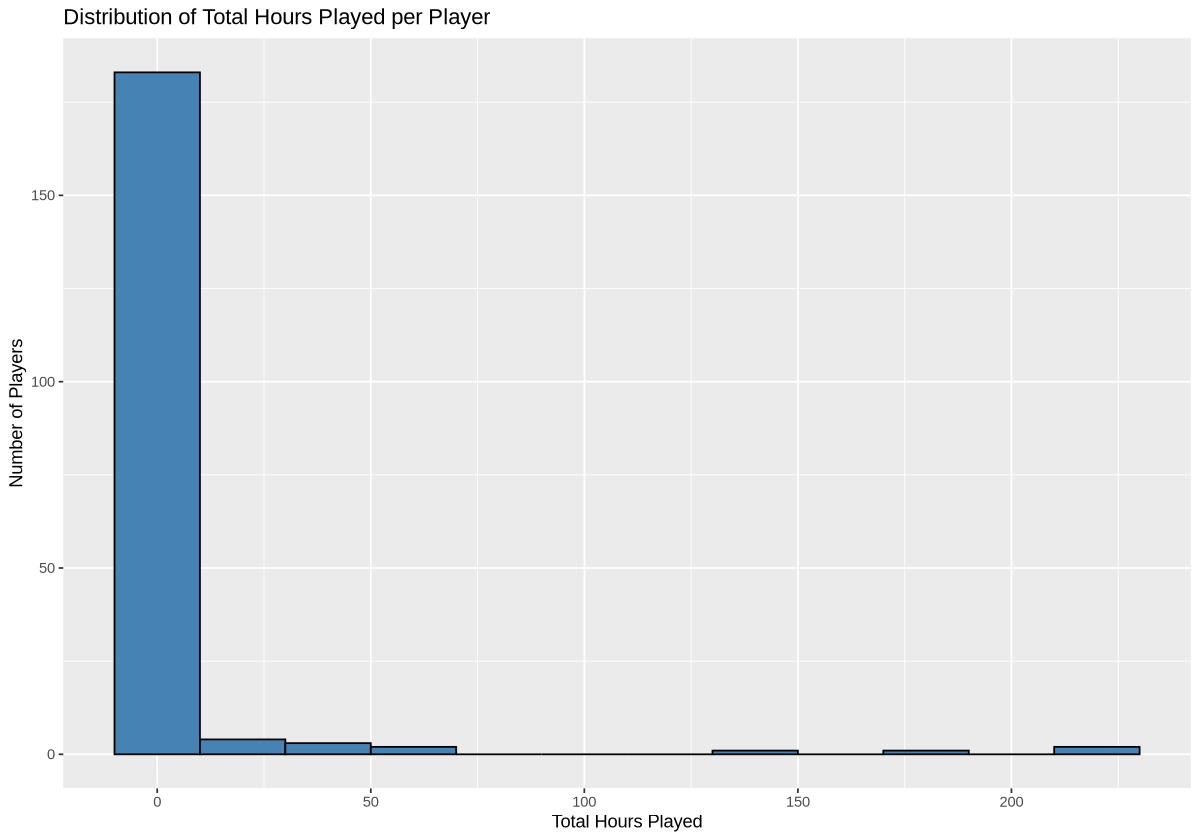

In [28]:
options(repr.plot.width = 10, repr.plot.height = 7) 
hours_played_plot <- ggplot(players, aes(x = played_hours)) +
    geom_histogram(binwidth = 20, fill = "steelblue", color = "black") +
    labs(title = "Distribution of Total Hours Played per Player",
         x = "Total Hours Played",
         y = "Number of Players")
hours_played_plot

**Insights**
- The distribution is highly skewed, as most players play a total of 0 hours
    - This suggests that most users rarely play, or only play for very short periods of time
- Some players have a very high number of hours played (> 200), which suggests the presence of outliers

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


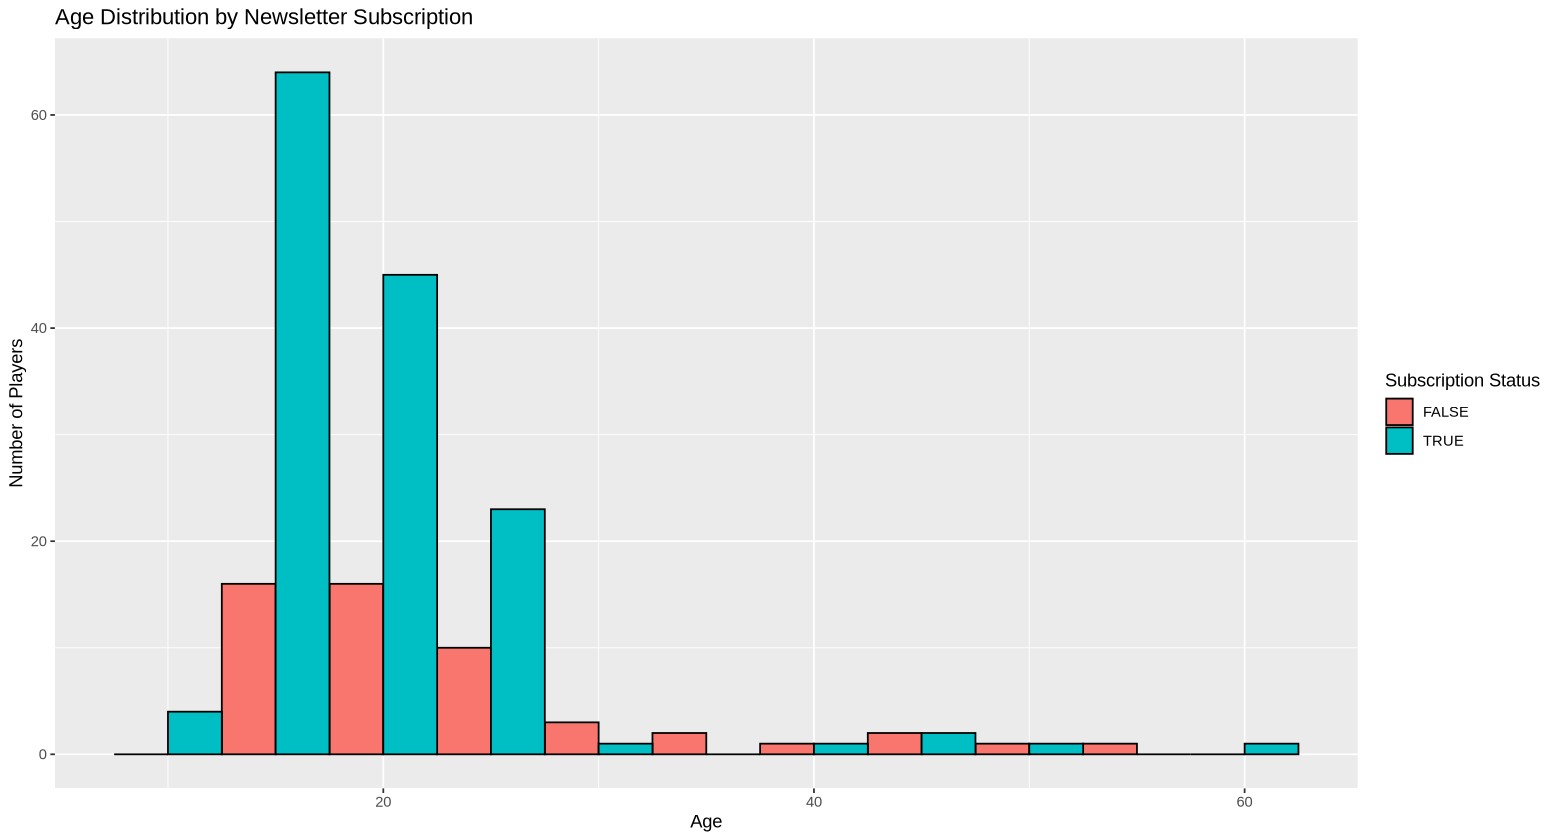

In [34]:
options(repr.plot.width = 13, repr.plot.height = 7) 
distribution_vs_subscription <- ggplot(players, aes(x = Age, fill = subscribe)) +
    geom_histogram(position = "dodge", binwidth = 5, color = "black") +
    labs(title = "Age Distribution by Newsletter Subscription",
         x = "Age (years)",
         y = "Number of Players",
         fill = "Subscription Status")
distribution_vs_subscription

**Insights**
- This plot shows that younger players make up the majority of the dataset (10-30 years old)
- Players subscribed to a game-related newsletter are more likely to be younger
- Non-subscribed players are more evenly distributed, and are more common among older players

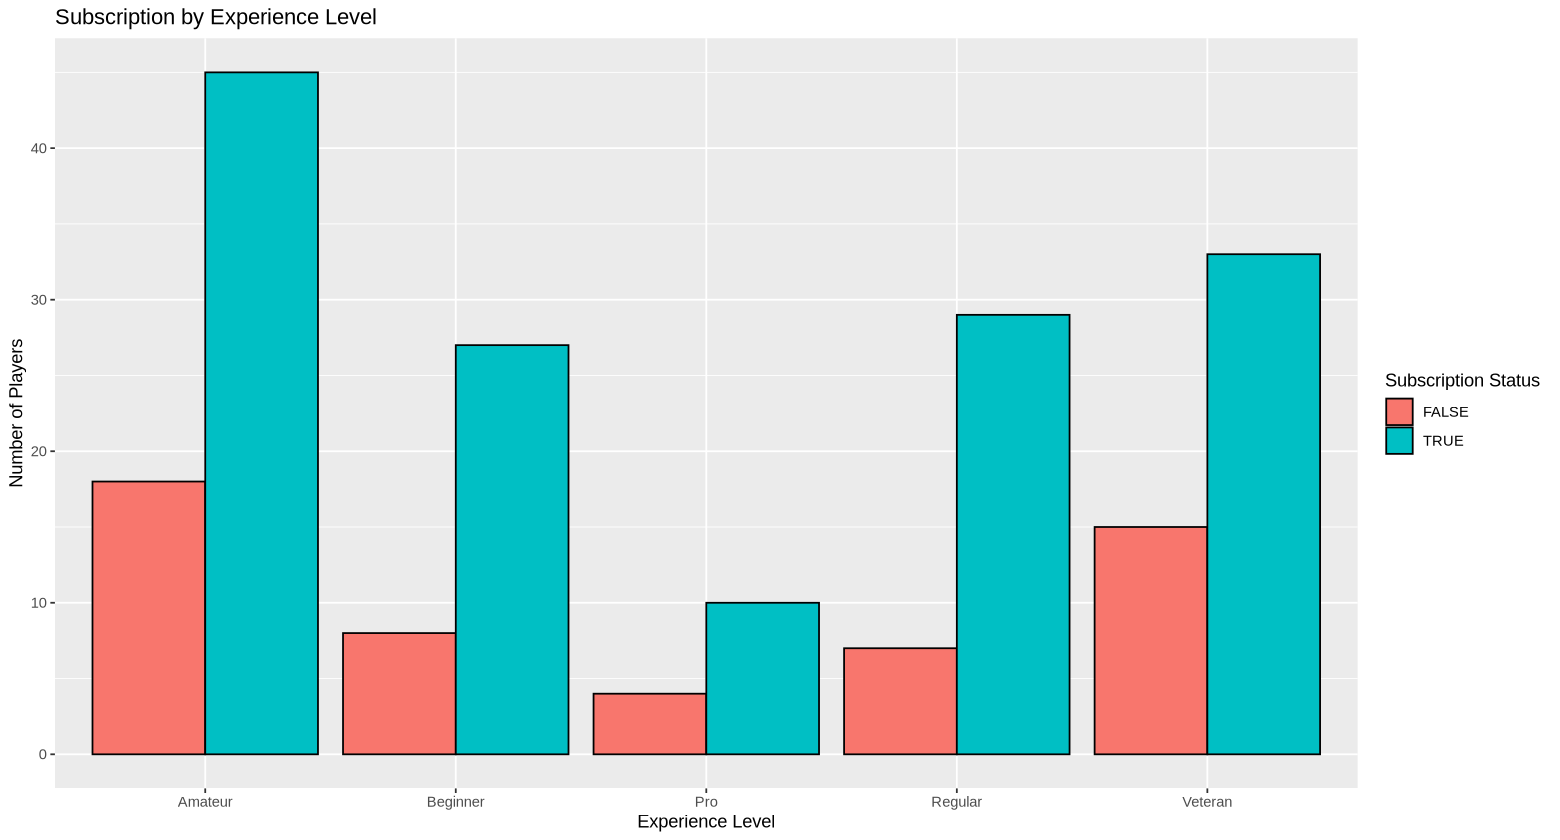

In [36]:
options(repr.plot.width = 13, repr.plot.height = 7) 
experience_vs_subscription <- ggplot(players, aes(x = experience, fill = subscribe)) +
    geom_bar(position = "dodge", color = "black") +
    labs(title = "Subscription by Experience Level",
         x = "Experience Level",
         y = "Number of Players",
         fill = "Subscription Status")
experience_vs_subscription

**Insights**
- Subscribed players outnumber non-subscribed players at every experience level
    - This suggests that at every level, any random player is more likely to be subscribed to a game-related newsletter
- The largest bar overall is the bar for subscribed amateur players
- The 'pro' category has the smallest bars for both subscribed and non-subscribed players, suggesting few players reach or self-identify as this level

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


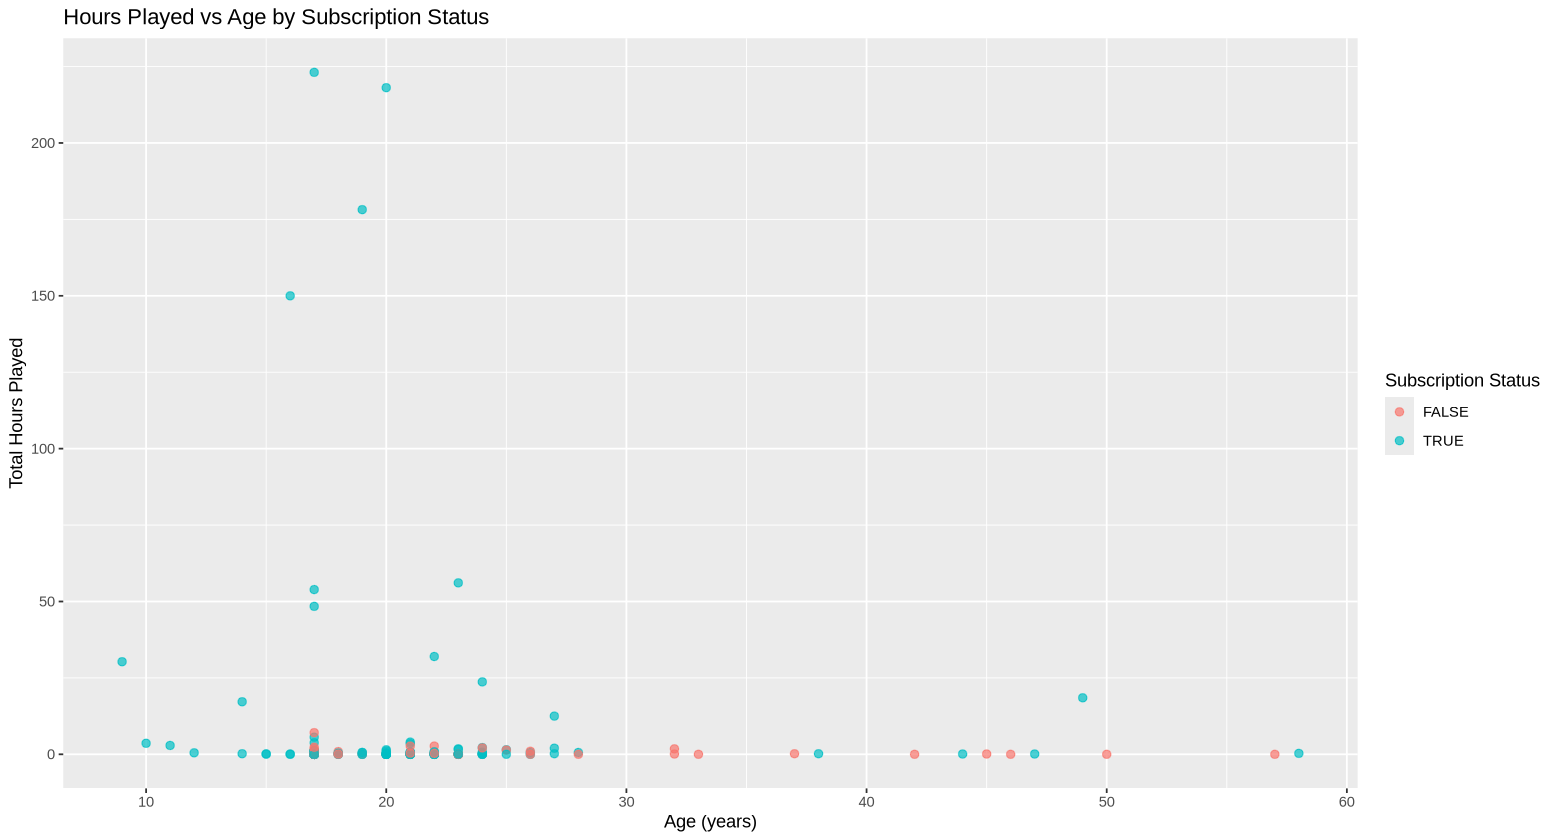

In [51]:
options(repr.plot.width = 13, repr.plot.height = 7) 
hours_vs_subscription <- ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.7, size = 2) +
    labs(title = "Hours Played vs Age by Subscription Status",
         x = "Age (years)",
         y = "Total Hours Played",
         color = "Subscription Status")
hours_vs_subscription

**Insights**
- Younger players (10-25 years old) tend to have higher total hours played, which suggests younger players spend much more time playing
- Players who are subscribed (blue points) have significantly higher played hours
    - The highest outliers are all subscribed to a game-related newsletter
    - This suggests that subscription status strongly correlates with hours played
- Non-subscribed players tend to log less hours played, as the majority of red points are close to the x-axis
- Older players (> 30) are generally less active in games regardless of subscription status
    - This suggests that above a certain age, hours played may not be a good predictor for subscription status

## Methods and Plan

I plan to use K-Nearest Neighbours Classification to predict whether a player is subscribed to a game-related newsletter based on their game activity patterns, such as total playtime, number of sessions, average session length, and experience level.

This method is appropriate because the relationship between activity metrics and subscription status is likely to be non-linear, and K-NN makes predictions based on the similarity of a player to other players in the dataset. K-NN is able to handle both numeric and categorical variables, which applies to this situation as there are predictors such as experience level and hours played.

Some assumptions that must be made include: observations are independent of each other; the chosen distance metric appropriately reflects the similarity between players; the features are scaled and balanced so that all predictors contribute equally to the distance calculation. 

Some potential limitations of this method include: K-NN performance may worsen with large datasets because the distances must be computed for all points in the training data; K-NN is highly sensitive to noise, outliers and imbalanced data.

I will compare and select the model by first tuning the number of neighbours using cross-validation on the training set, and then assessing its performance using metrics such as accuracy, precision, and recall. I will then select the model with the best cross-validated performance on the training set.

I will split the dataset into training (70%) and testing (30%) sets, and I will apply standardisation before training the model to ensure fair distance calculations. I will apply 5-fold cross-validation to the trainig set to tune the hyperparameters, and the testing set will only be used after selecting and tuning the model to evaluate the final performance.